In [118]:
%matplotlib inline
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [119]:
with open('210.csv', 'r') as f:
    a = f.readlines()

In [120]:
feature = []
score = []
for item in a:
    line = item.strip().split(',')
    feature.append(line[2:])
    score.append(line[1])

In [121]:
score = np.array(score).astype(np.float)
feature = np.array(feature).astype(np.float)
print(score.shape, feature.shape)

(2379,) (2379, 4561)


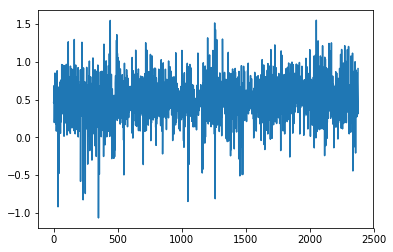

In [122]:
plt.figure()
plt.plot(score)

In [123]:
b = np.sort(score)

In [124]:
b

array([-1.06661228, -0.91904114, -0.84838697, ...,  1.51543179,
        1.54828723,  1.55139751])

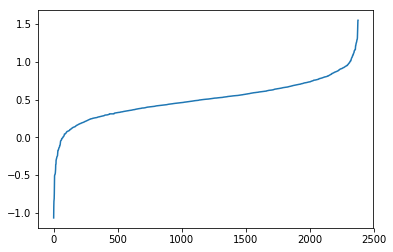

In [125]:
plt.figure()
plt.plot(b)

(array([   5.,    2.,   16.,   41.,  223.,  900.,  872.,  264.,   47.,    9.]),
 array([-1.06661228, -0.8048113 , -0.54301032, -0.28120934, -0.01940836,
         0.24239262,  0.50419359,  0.76599457,  1.02779555,  1.28959653,
         1.55139751]),
 <a list of 10 Patch objects>)

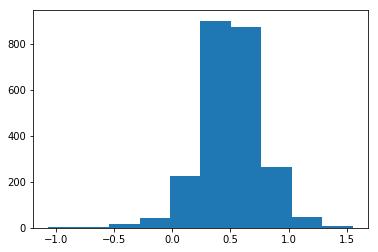

In [126]:
plt.figure()
plt.hist(score)

In [127]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

In [131]:
class BaseNet(nn.Module):
    def __init__(self, num_input, num_hidden):
        super(BaseNet, self).__init__()
        self.fc1 = nn.Linear(num_input, num_hidden)
        self.bn1 = nn.BatchNorm1d(num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.bn2 = nn.BatchNorm1d(num_hidden)
        self.fc3 = nn.Linear(num_hidden, num_hidden)
        self.bn3 = nn.BatchNorm1d(num_hidden)
        self.fc4 = nn.Linear(num_hidden, num_hidden)
        self.bn4 = nn.BatchNorm1d(num_hidden)
        self.fc5 = nn.Linear(num_hidden, num_hidden)
        self.bn5 = nn.BatchNorm1d(num_hidden)
        self.fc = nn.Linear(num_hidden, 3)

    def forward(self, x1, x2):
        x1 = F.relu(self.bn1(self.fc1(x1)))
        x1 = F.relu(self.bn2(self.fc2(x1)))
        x1 = F.relu(self.bn3(self.fc3(x1)))
        x2 = F.relu(self.bn1(self.fc1(x2)))
        x2 = F.relu(self.bn2(self.fc2(x2)))
        x2 = F.relu(self.bn3(self.fc3(x2)))
        x = x1 - x2
        x = F.relu(self.bn4(self.fc4(x)))
        x = F.relu(self.bn5(self.fc5(x)))
        y = self.fc(x)
        return y

In [132]:
def get_next_batch(feature, score, batch_size=256):
    idx1 = np.random.randint(score.shape[0], size=batch_size)
    idx2 = np.random.randint(score.shape[0], size=batch_size)
    x1 = feature[idx1, :]
    x2 = feature[idx2, :]
    score_diff = score[idx1] - score[idx2]
    y = np.zeros_like(score_diff)
    thresh = 0.8
    y[score_diff >= thresh] = 1
    y[np.abs(score_diff) < thresh] = 0
    y[score_diff <= -thresh] = 2
    return x1, x2, y

In [133]:
model = BaseNet(feature.shape[1], 2048)
if torch.cuda.is_available():
    model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
acc_all = []
for epoch in range(1000):
    optimizer.zero_grad()
    x1, x2, gt = get_next_batch(feature, score)
    x1 = Variable(torch.from_numpy(x1).float())
    x2 = Variable(torch.from_numpy(x2).float())
    gt = Variable(torch.from_numpy(gt).long())
    if torch.cuda.is_available():
        x1, x2, gt = x1.cuda(), x2.cuda(), gt.cuda()
    y = model(x1, x2)
    # loss = torch.abs(y - target).sum()
    loss = F.cross_entropy(y, gt)
    pred = y.data.max(1)[1]
    acc = pred.eq(gt.data).cpu().sum() * 1.0 / gt.numel()
    acc_all.append(acc)
    loss.backward()
    optimizer.step()
    if epoch > 100:
        acc_all.pop(0)
    ave_acc = sum(acc_all) / float(len(acc_all))
    print('epoch %d: loss %.4f, acc: %.4f' % (epoch, loss.data[0], ave_acc))

RuntimeError: cuda runtime error (59) : device-side assert triggered at /pytorch/torch/lib/THC/generic/THCStorage.cu:66